In [1]:
import numpy as np
import seaborn as sns
import os 
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib_venn import venn3
import gseapy
import scanpy as sc
import pandas as pd
np.random.seed(0)

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map='viridis')
sc.logging.print_header()
sc.settings.savefigs = False  

2023-01-27 20:43:26.077709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 20:43:33.590481: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/christos/miniconda3/envs/ml/lib/
2023-01-27 20:43:33.590678: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/christos/miniconda3/envs/ml/lib/
2023-01-27 20:43:33.590691: W tensorflow/compiler/

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.3 louvain==0.8.0 pynndescent==0.5.8


In [4]:
Root_Folder = "/home/christos/Desktop/Alethiomics"#Please adapt root folder accordingly.
os.chdir(Root_Folder)

In [5]:
#Dataset filenames
filename_mESC ='./data/Gastr/Rna_scNMT_gastr.tsv'
#_mESC is used to denote mouse Embryonic stem cells published by Argelaguet (Multi-omics profiling of mouse gastrulation at single-cell resolution)

In [6]:
%%time
#Load Datasets
adata_mESC = sc.read(filename_mESC,cache=True).transpose()
Days = [xx.split('_')[0] for xx in list(adata_mESC.obs_names)]
adata_mESC.obs["E_days"] = Days
sc.logging.print_memory_usage()

... reading from cache file cache/data-Gastr-Rna_scNMT_gastr.h5ad
Memory usage: current 0.84 GB, difference +0.84 GB
CPU times: user 711 ms, sys: 137 ms, total: 849 ms
Wall time: 1.33 s


# Quality Control

In [7]:
#Estimate QC metrics for the data.
sc.pp.calculate_qc_metrics(adata_mESC, percent_top=None, log1p=False, inplace=True)

In [8]:
#Filter out genes that are not expressed in any cell and normalize datasets

sc.pp.filter_genes(adata_mESC, min_cells = 1)
sc.pp.normalize_per_cell(adata_mESC)# normalize _mESC with total UMI count per cell
adata_mESC=adata_mESC[adata_mESC.obs["E_days"]!='PS']

filtered out 816 genes that are detected in less than 1 cells
normalizing by total count per cell
filtered out 5 cells that have less than 1 counts
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [9]:
#Keep 5000 genes with the highest dispersion.

filter_result_mESC = sc.pp.filter_genes_dispersion(adata_mESC.X, flavor='cell_ranger', n_top_genes=5000, log=False)
sc.pp.filter_genes_dispersion(adata_mESC, flavor='cell_ranger', n_top_genes=5000, log=False)


extracting highly variable genes
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)


/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:129: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['means'] = result['means']


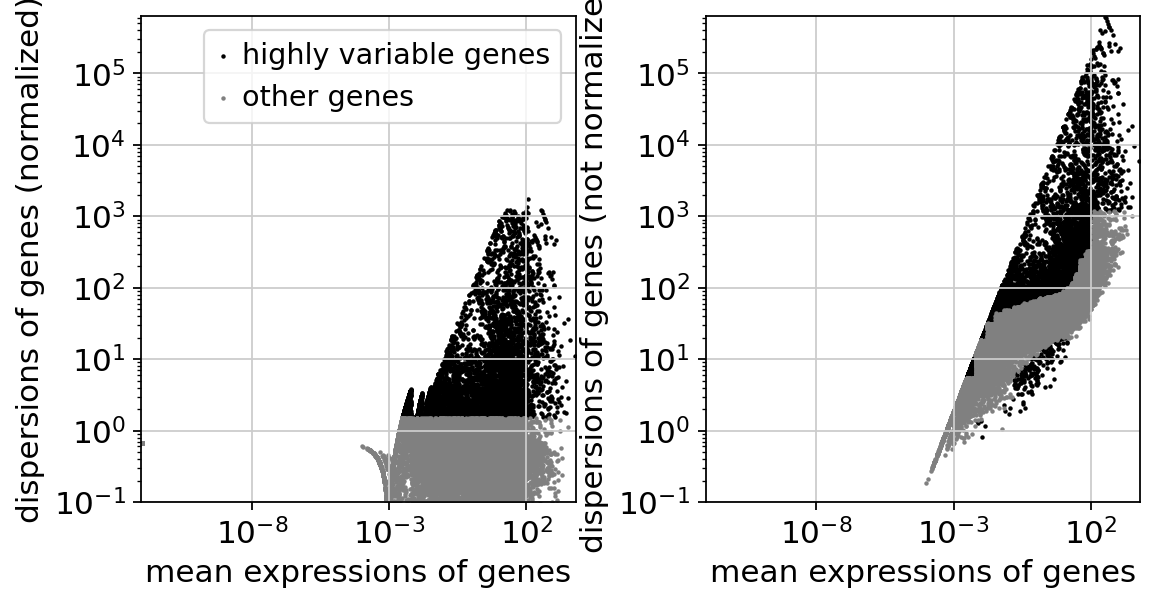

In [10]:
sc.pl.filter_genes_dispersion(filter_result_mESC, log=True)

# Preprocessing and graph clustering

In [11]:
#Estimating low dimensional embeddings with PCA and Umap
sc.pp.normalize_per_cell(adata_mESC)
sc.pp.scale(adata_mESC) #scale _mESC data
sc.tl.pca(adata_mESC, n_comps=50,random_state=0)
sc.pp.neighbors(adata_mESC, n_neighbors=20, n_pcs=50,random_state=0)
sc.tl.umap(adata_mESC,random_state=0)
sc.tl.leiden(adata_mESC, key_added = "leiden_1.0",random_state=0)
sc.logging.print_memory_usage()

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:00)
Memory usage: current 0.68 GB, difference -0.16 GB


drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:04)


/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


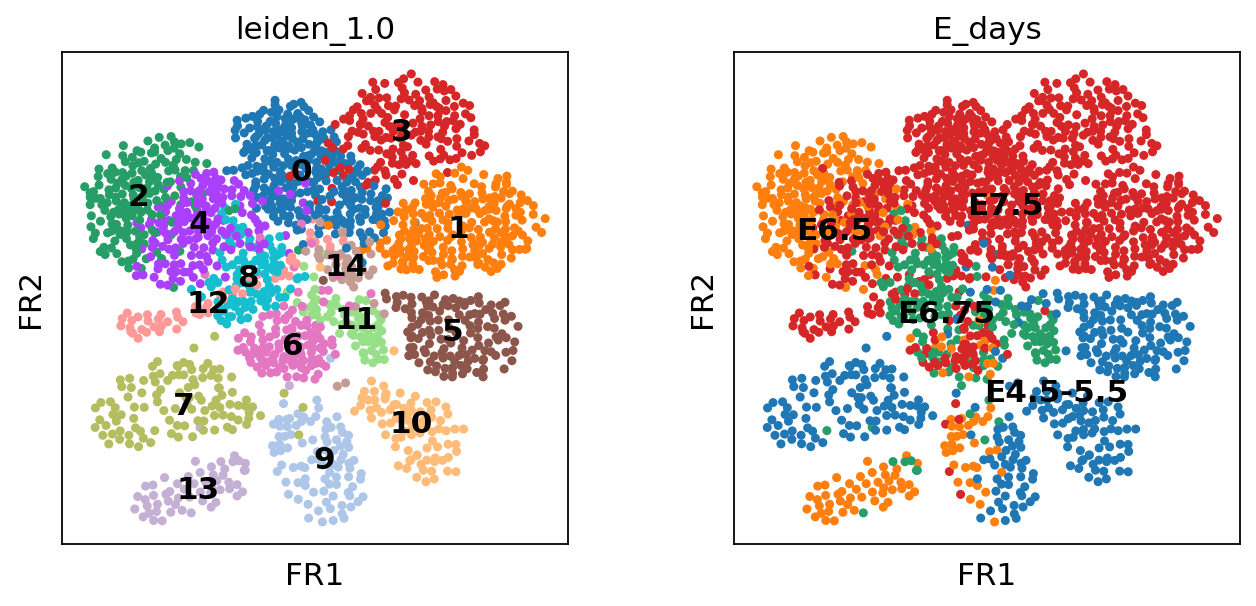

In [12]:
sc.tl.draw_graph(adata_mESC)
sc.pl.draw_graph(adata_mESC, color=['leiden_1.0','E_days'],legend_loc = 'on data')

# Wilcoxon rank-sum

In [13]:
#Wilcoxon rank-sum for leiden clusters.
#To identify genes with the highest differential expression in each cluster, we use the wilcoxon test.  

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name,

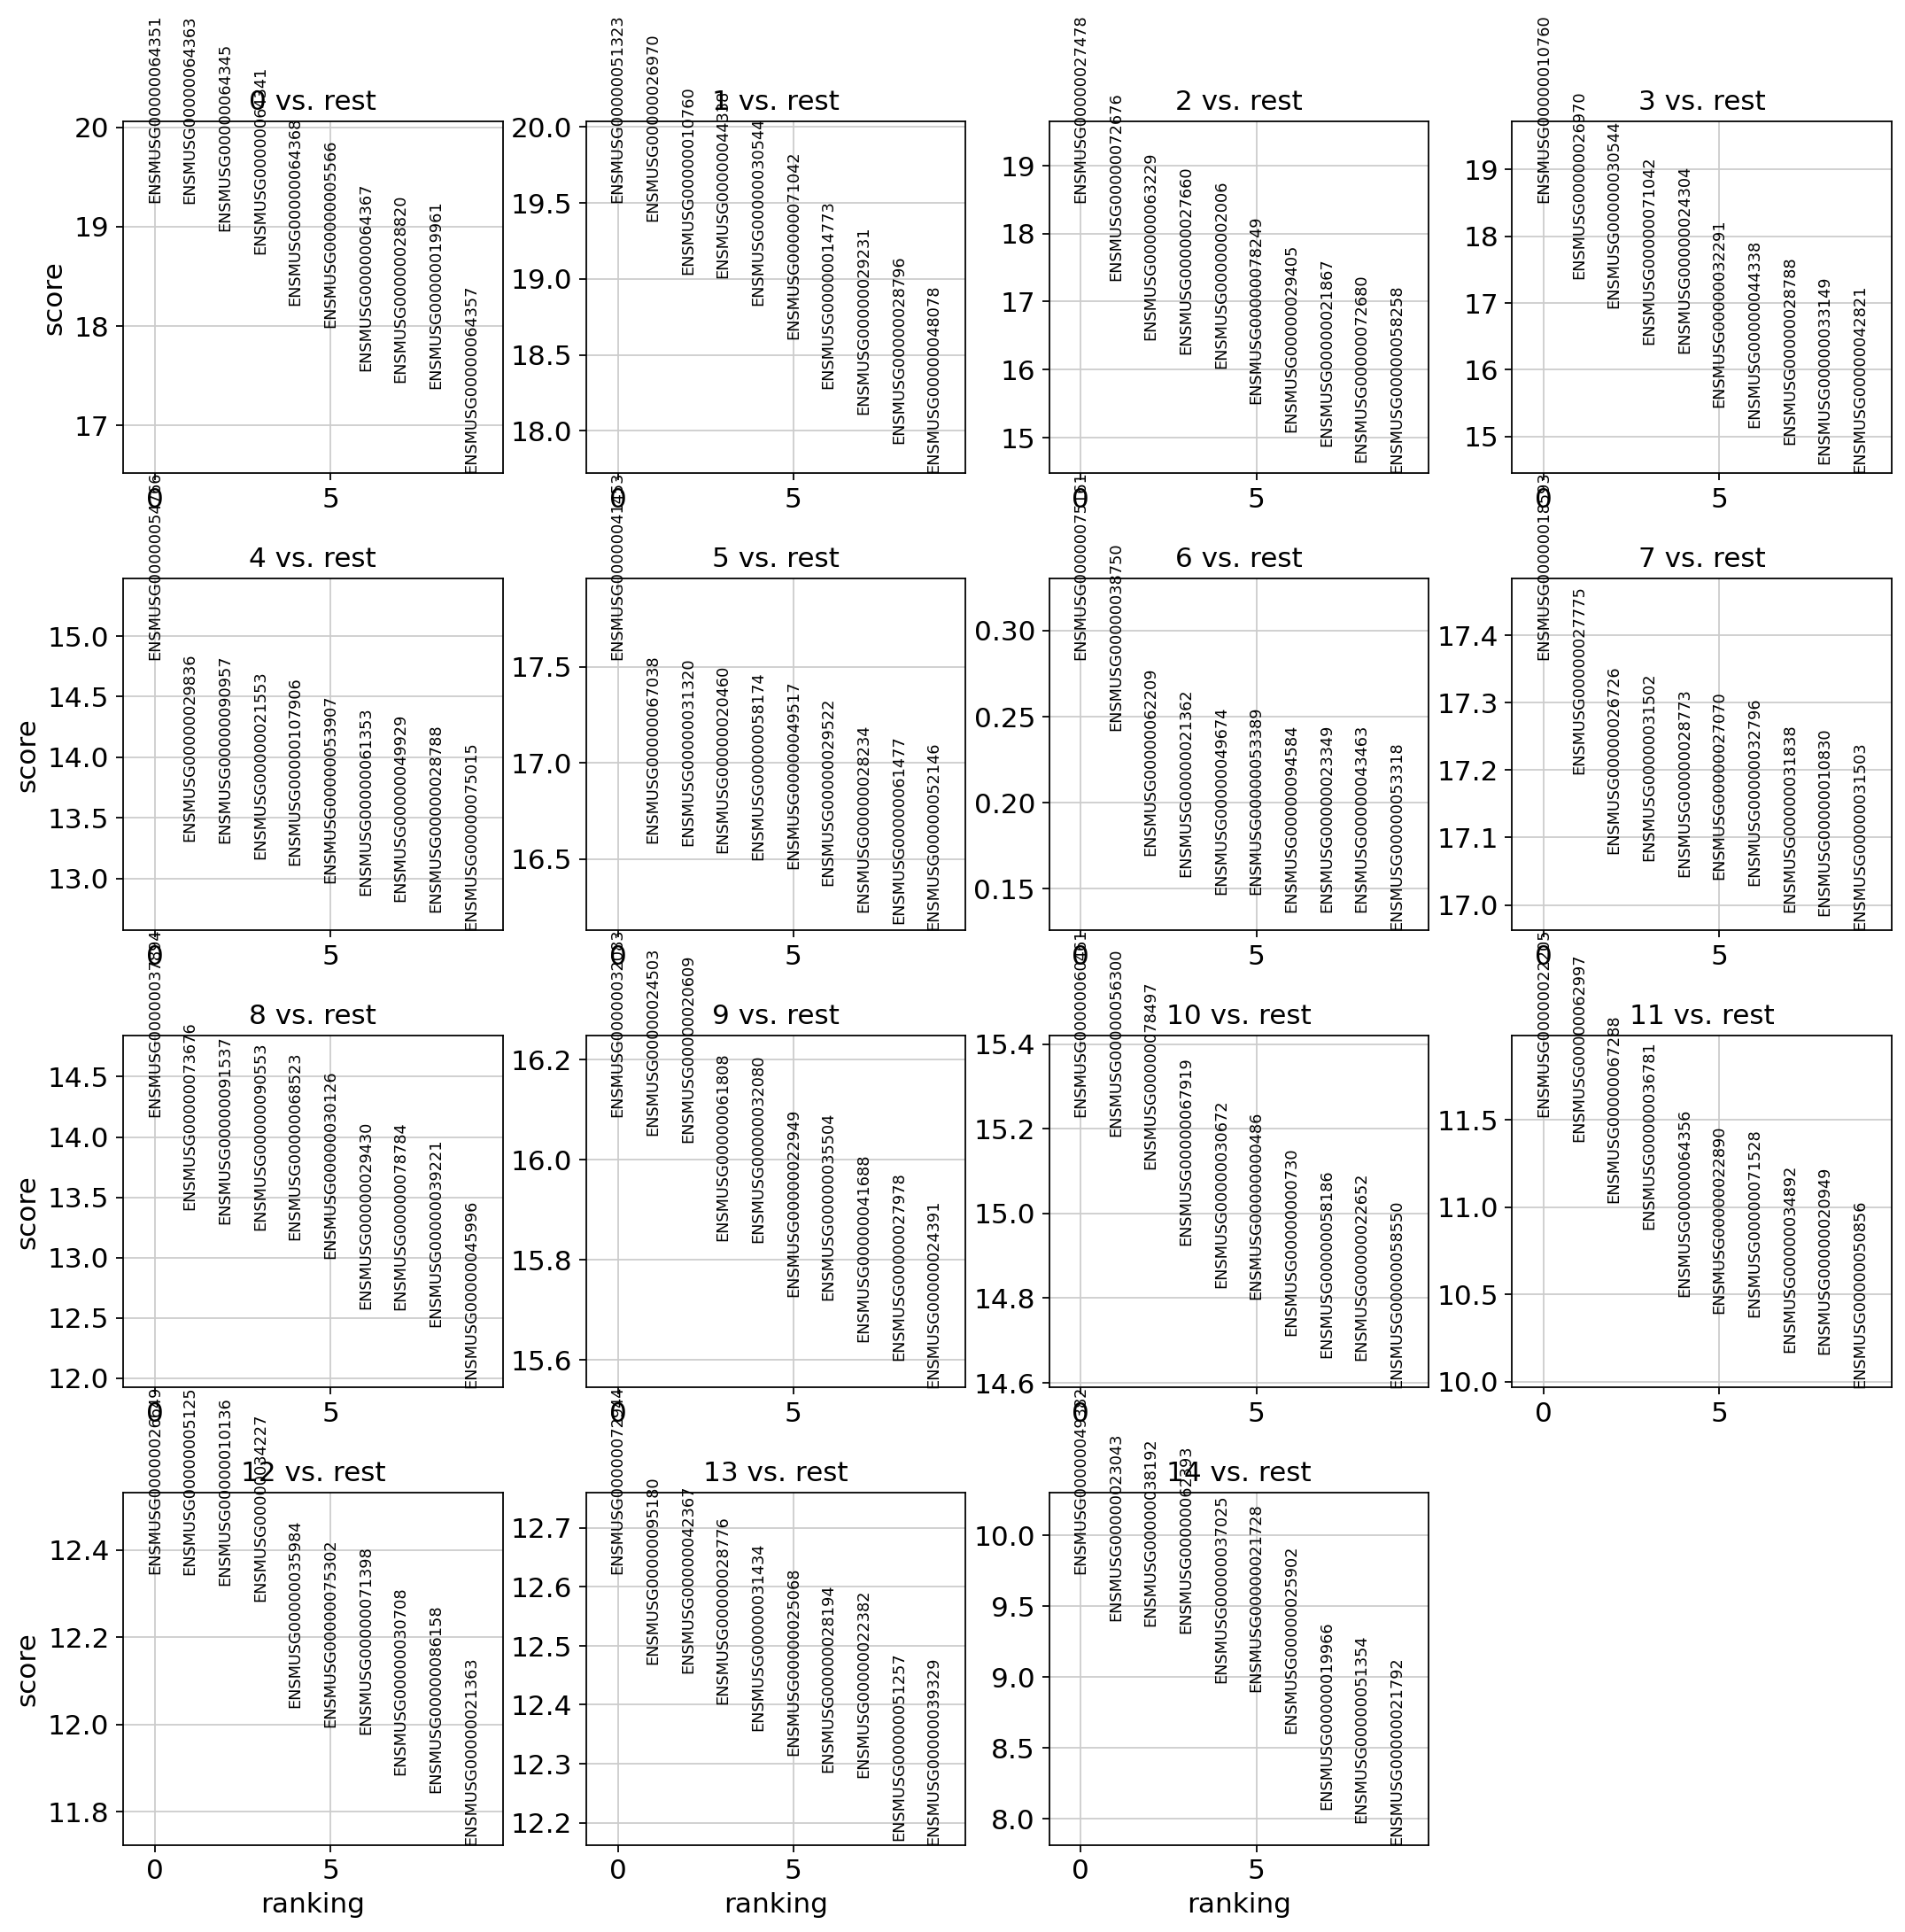

In [14]:
gns=10
sc.tl.rank_genes_groups(adata_mESC, 'leiden_1.0', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata_mESC, n_genes=gns, sharey=False, key="wilcoxon")

#In clusters 2 and 10 we identify dnmt3b and dppa5a respectively. Dnmt3b is a member of the DNA Methyltransferases family
# which encodes the de novo methyltransferases, required to establish and maintain genomic methylation.
#Dppa5a is member of the developmental pluripotency family. Recent studies reveal different facets of developmental pluripotency factors in balancing a controlled and directed exit from pluripotency. 
#(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4684880/)

# Visualization

In [15]:
#To visualize the expression of top 5 DE genes for each cluster, we use the following command.

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_1.0']`


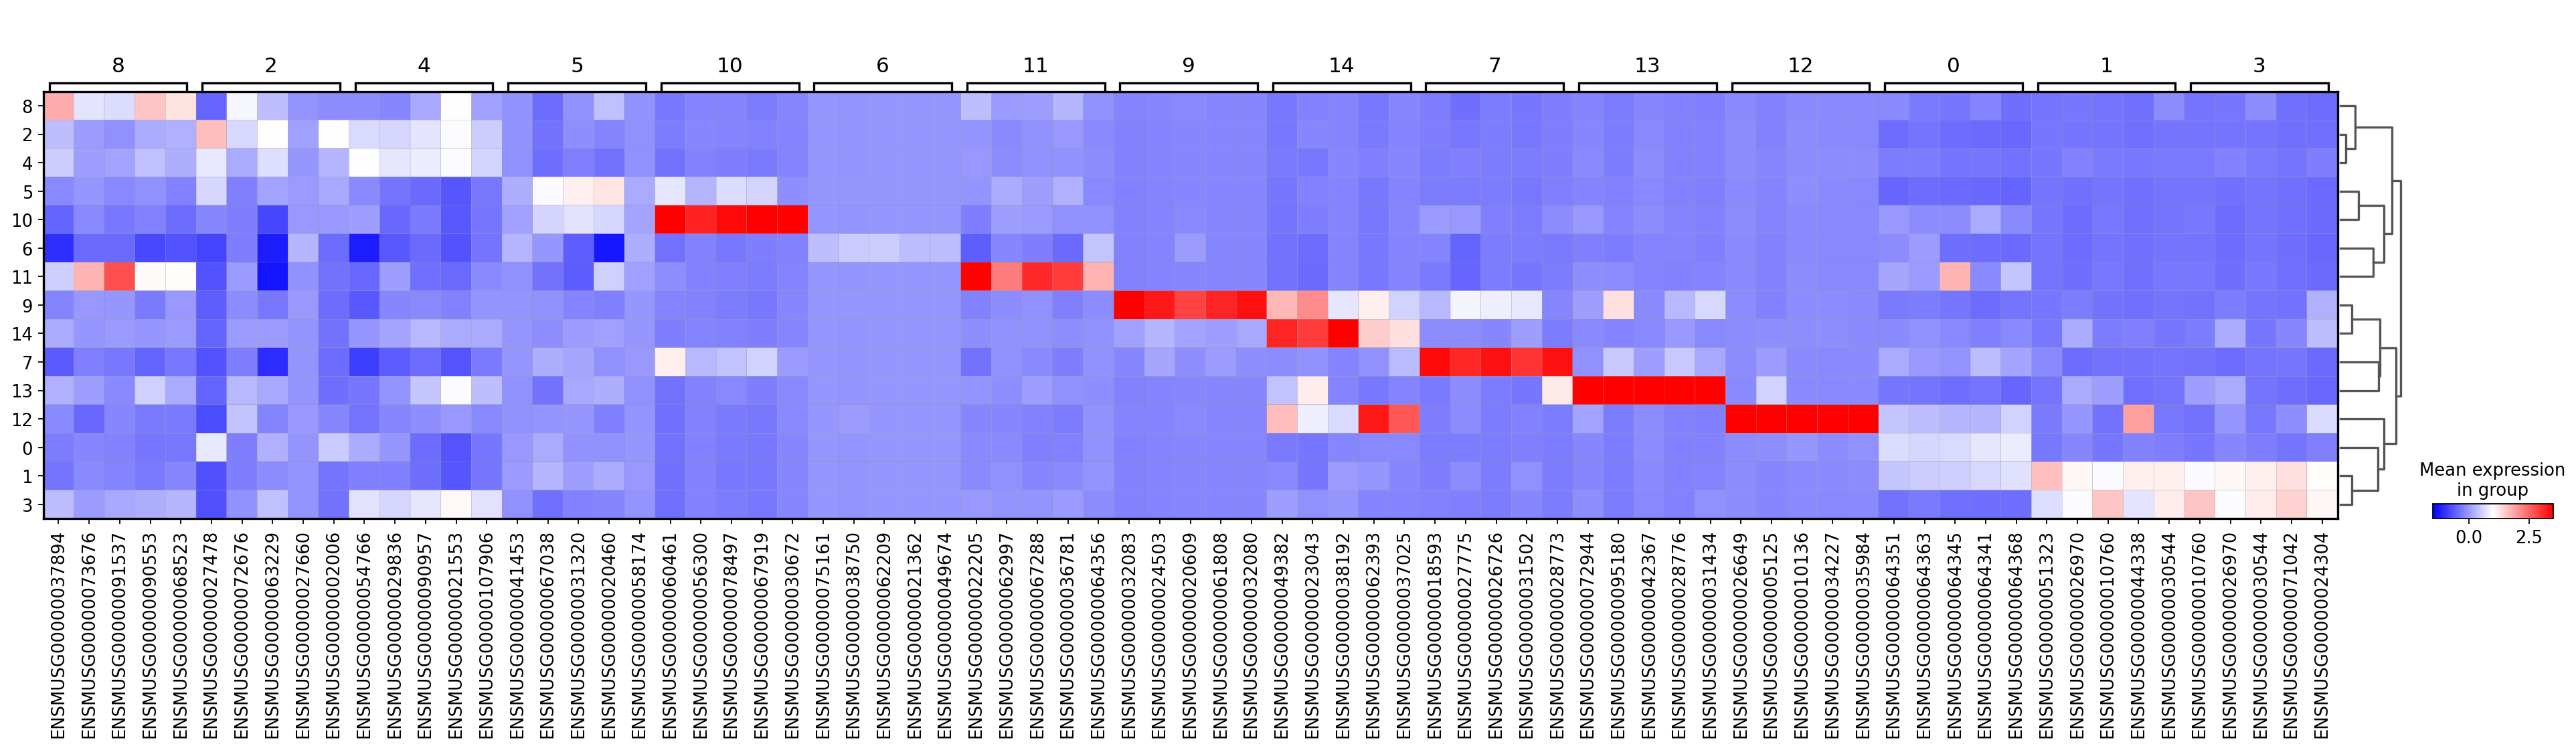

In [16]:
sc.pl.rank_genes_groups_matrixplot(adata_mESC, 
                                   n_genes=5, 
                                   key="wilcoxon",
                                   groupby="leiden_1.0",
                                   cmap='bwr',
                                   vmin=-1.5,
                                   vmax=3.5,)

# Compare specific clusters

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


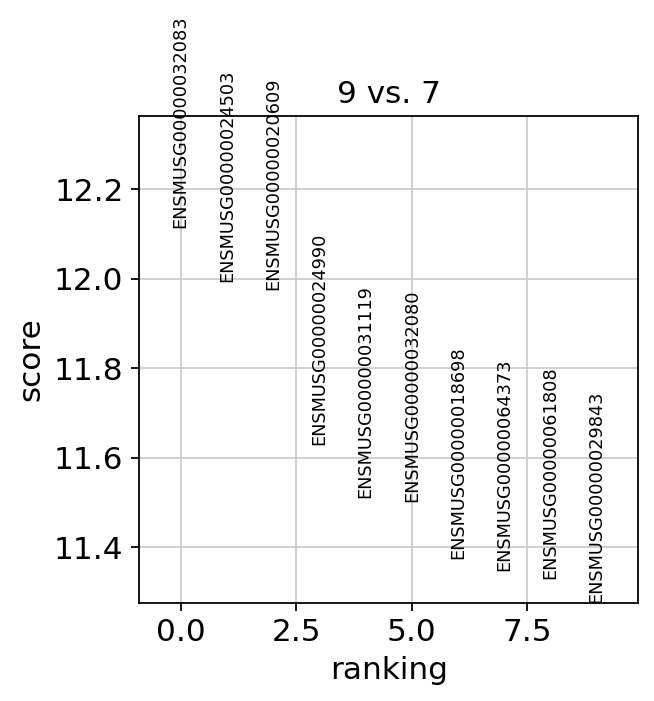

/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


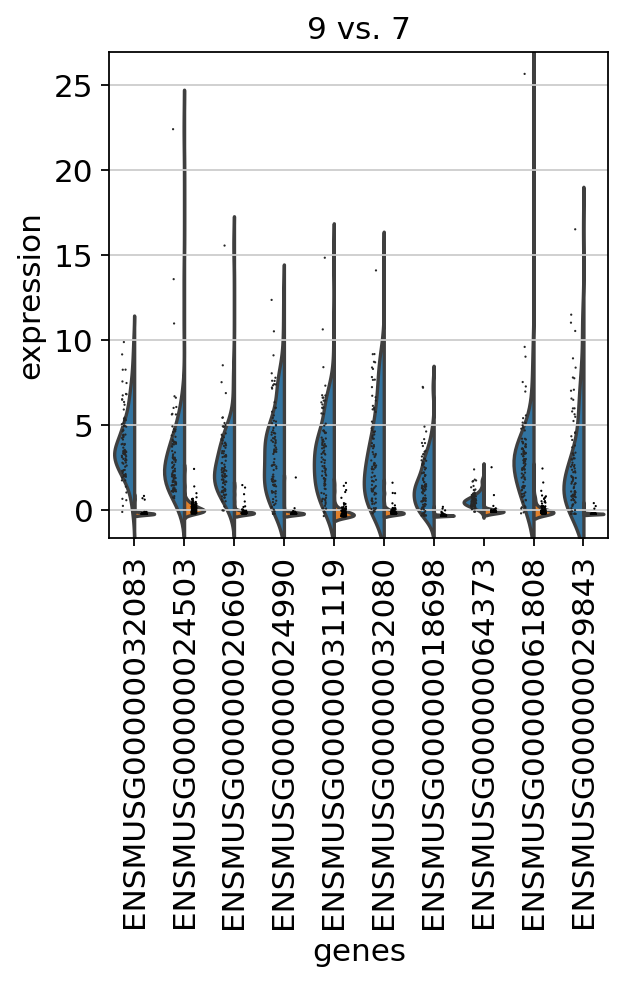

In [17]:
#A more refined analysis could be performed by comparing differentially expressed gene between two clusters.
sc.tl.rank_genes_groups(adata_mESC, 'leiden_1.0', groups=['9'], reference='7', method='wilcoxon')
sc.pl.rank_genes_groups(adata_mESC, groups=['9'], n_genes=10)
sc.pl.rank_genes_groups_violin(adata_mESC, groups='9', n_genes=10)

## Differential expression across embryonic days for specific clusters

In [18]:
cl9 = adata_mESC[adata_mESC.obs['leiden_1.0'] == '4',:] 
cl9.obs['E_days'].value_counts()

E7.5    136
E6.5     24
Name: E_days, dtype: int64

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/christos/miniconda3/envs/ml/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


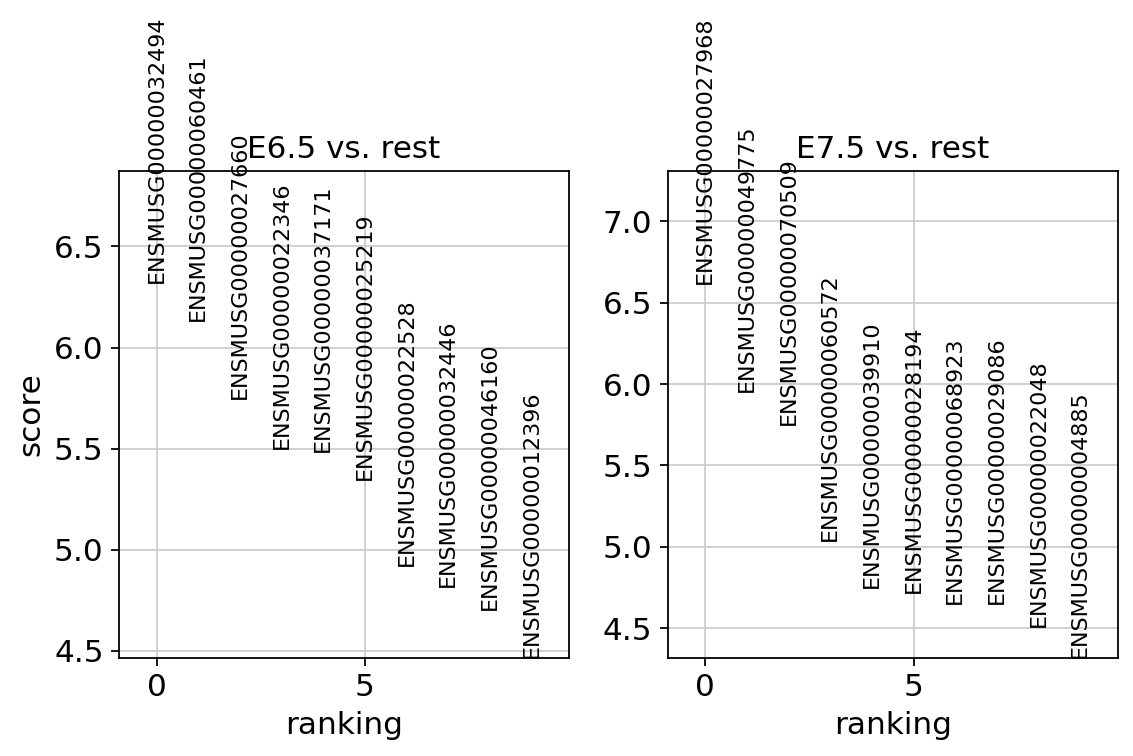

In [19]:
sc.tl.rank_genes_groups(cl9, 'E_days', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl9, n_genes=10, sharey=False, key="wilcoxon", fontsize=10)

#Interesting discovery is growth factor Tdgf1 in cells at E6.5 

#sc.pl.rank_genes_groups_violin(cl9, n_genes=10, key="wilcoxon")

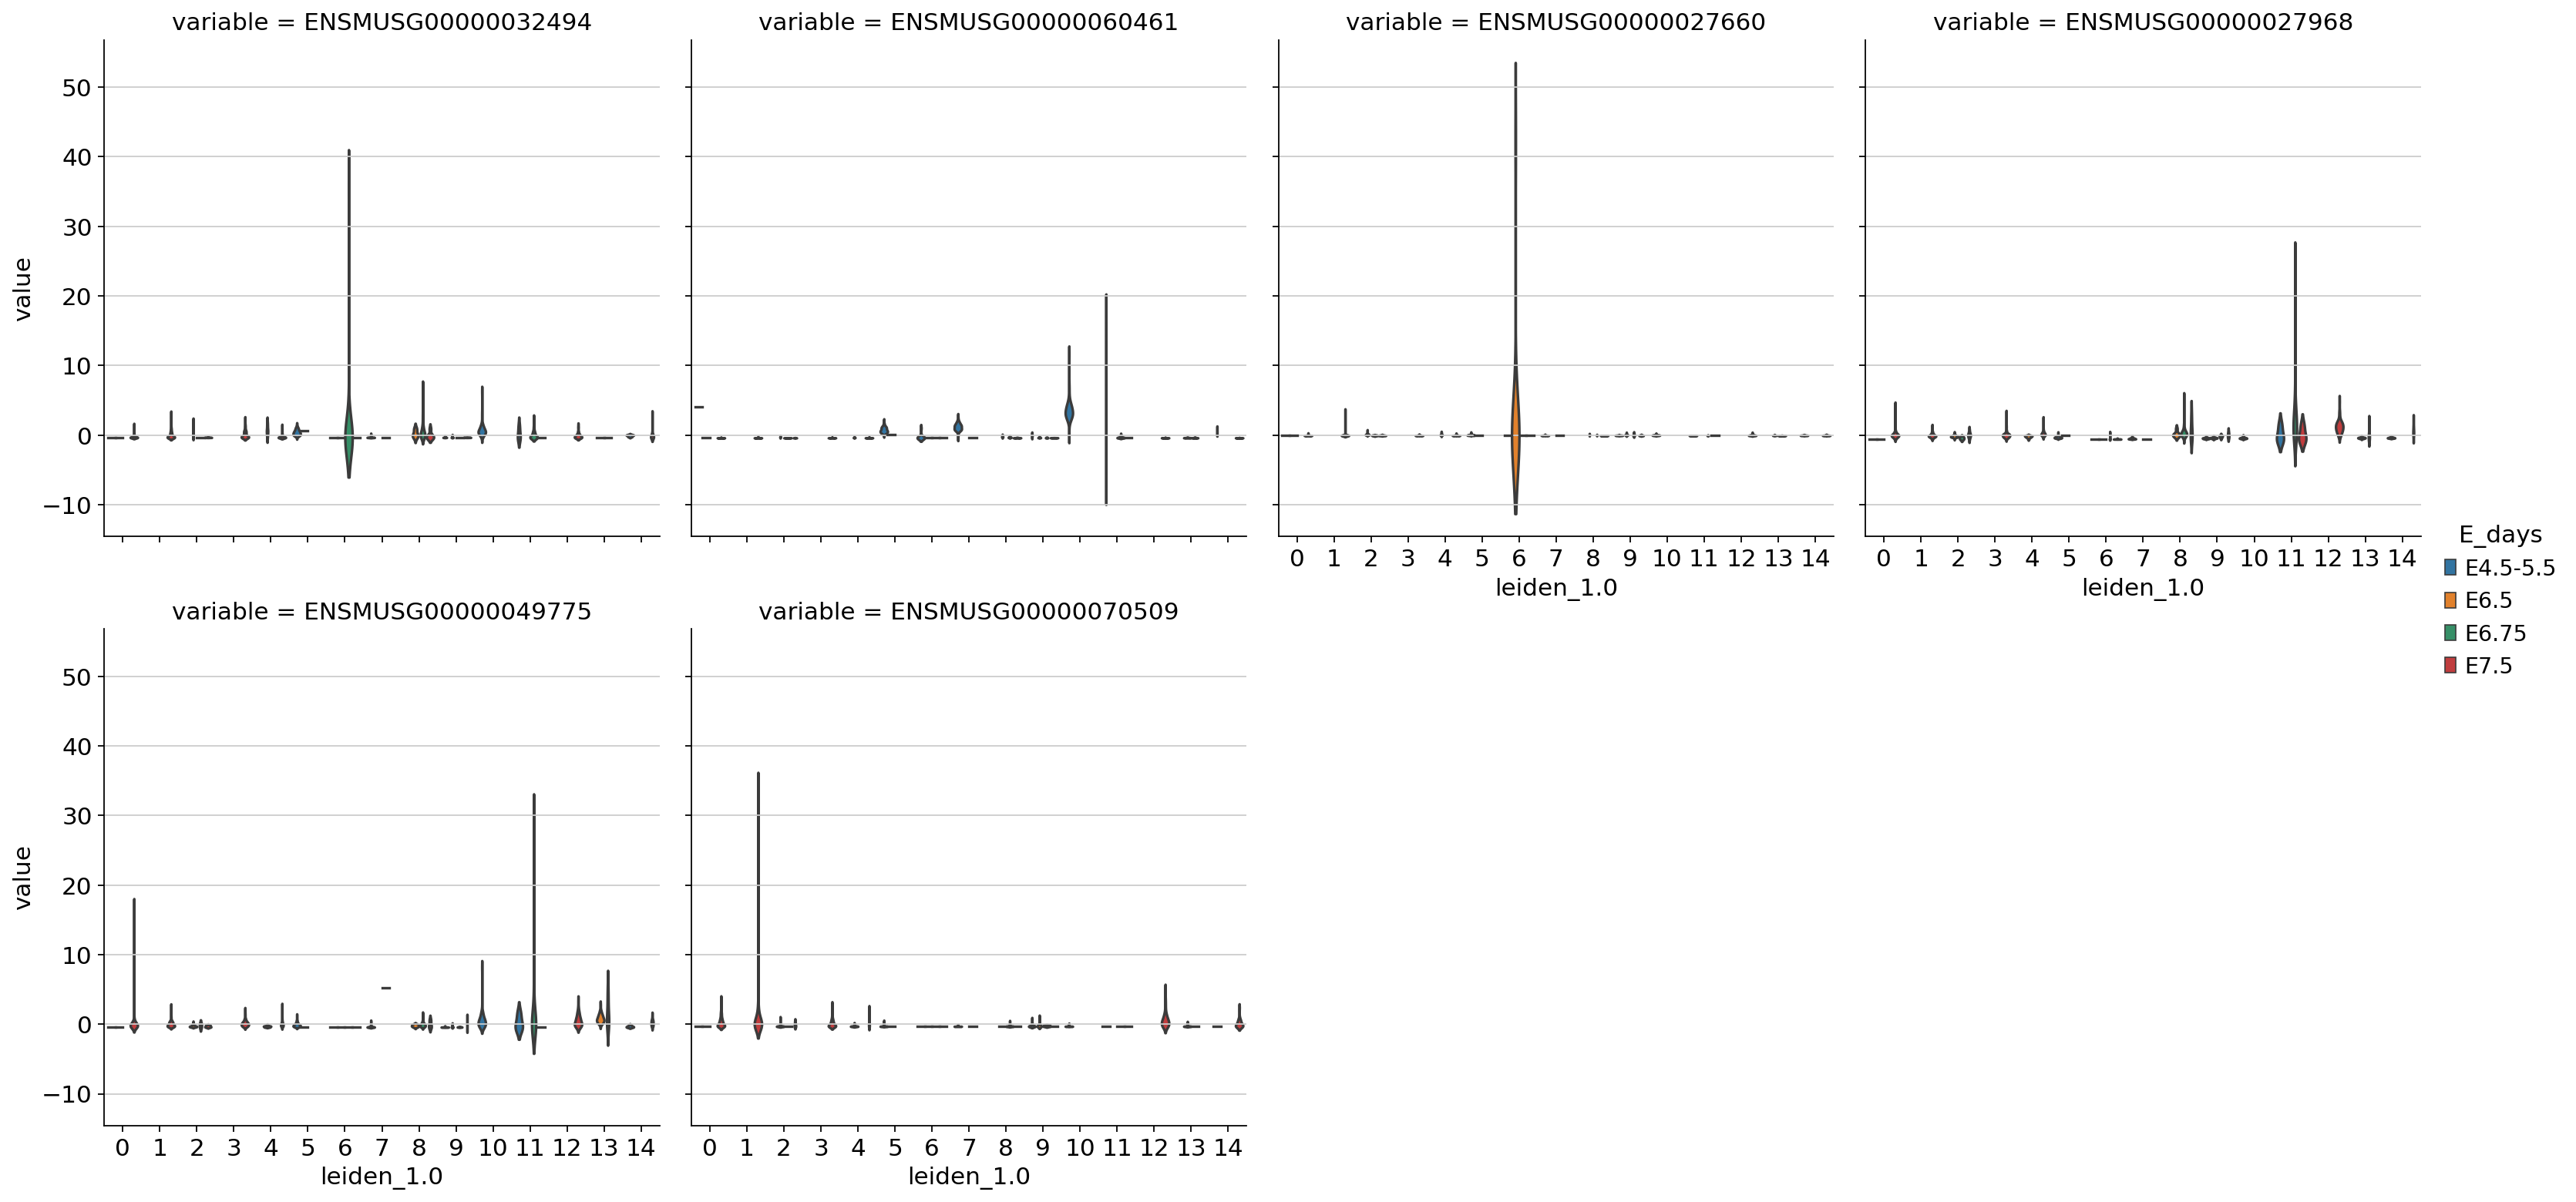

In [20]:
#We can also plot these genes across all clusters, but split by "E_days", 
#to check if the genes are also up/downregulated in other cell types.

genes1 = sc.get.rank_genes_groups_df(cl9, group='E6.5', key='wilcoxon')['names'][:3]
genes2 = sc.get.rank_genes_groups_df(cl9, group='E7.5', key='wilcoxon')['names'][:3]
genes = genes1.tolist() +  genes2.tolist() 
df = sc.get.obs_df(adata_mESC, genes + ['leiden_1.0','E_days'], use_raw=False)
df2 = df.melt(id_vars=["leiden_1.0",'E_days'], value_vars=genes)

sns.catplot(x = "leiden_1.0", y = "value", hue = "E_days", kind = 'violin', 
               col = "variable", data = df2, col_wrap=4, inner=None)